# Data


In [130]:
import os
import pandas as pd
import numpy as np
from ament_index_python.packages import get_package_share_directory


# Define the file path
oscillations_file = os.path.join(
    get_package_share_directory("furuta_pendulum_model"),
    "data",
    "hardware_pure_joint1_oscillations.csv",
)


x_columns = [
    "/joint_states/joint1/position",
    "/joint_states/joint1/velocity",
]

# Define the starting index
starting_idx = 10

In [131]:
class CustomDataset:
    def __init__(self, csv_file, x_columns, starting_idx):
        self.time_col = "/joint_states/header/stamp"
        self.x_columns = x_columns

        # Read only the necessary columns
        self.data = pd.read_csv(
            csv_file,
            skiprows=range(1, starting_idx),
            usecols=self.x_columns + [self.time_col],
        )

        self.normalize_data()

    def get_timestamp(self, idx):
        return self.data.iloc[idx][self.time_col]

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        return sample[self.x_columns]

    def __len__(self):
        return len(self.data)

    def normalize_data(self):
        offset_values = self.data.iloc[0][self.time_col]
        self.data[self.time_col] -= offset_values


# Create the custom dataset
dataset = CustomDataset(oscillations_file, x_columns, starting_idx)

20135


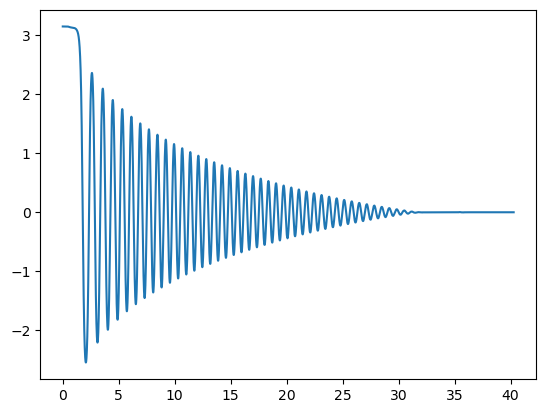

In [132]:
from matplotlib.pyplot import plot

velocity = [x[0] for x in dataset]
timestamps = [dataset.get_timestamp(idx) for idx in range(len(dataset))]

plot(timestamps, velocity)
print(len(timestamps))

# Simulation

In [133]:
import yaml
import os
from ament_index_python.packages import get_package_share_directory

pendulum_params_file = os.path.join(
    get_package_share_directory("furuta_pendulum_description"),
    "config",
    "pendulum_parameters.yaml",
)

with open(pendulum_params_file, "r") as file:
    pendulum_params = yaml.safe_load(file)["/**"]["ros__parameters"]


m2 = pendulum_params["m2"]
l2 = pendulum_params["l2"]
J2 = pendulum_params["J2"]
b2 = pendulum_params["b2"]

initial_dy = -8.068083777769447e-06


In [134]:
import numpy as np
from scipy.integrate import odeint


class F_opt:
    def __init__(self, m2, l2, J2, b2):
        self.m2 = m2
        self.l2 = l2
        self.J2 = J2
        self.b2 = b2
        self.J2_hat = J2 + m2 * l2 * l2
        self.g = 9.80665

    def __call__(self, t, x):

        dx = np.zeros(2)
        dx[0] = x[1]
        dx[1] = (
            1.0
            / self.J2_hat
            * (-self.m2 * self.g * self.l2 * np.sin(np.pi - x[0]) - self.b2 * x[1])
        )

        return dx


from scipy.integrate import solve_ivp


def create_trajectory(timestamps, m2, l2, J2, b2, initial_dy):
    f_opt = F_opt(m2, l2, J2, b2)
    return solve_ivp(
        f_opt,
        t_span=[timestamps[0], timestamps[-1]],
        y0=[np.pi, initial_dy],
        t_eval=timestamps,
    ).y
    # return odeint(f_opt, y0=[np.pi, -0.00001], t=timestamps)

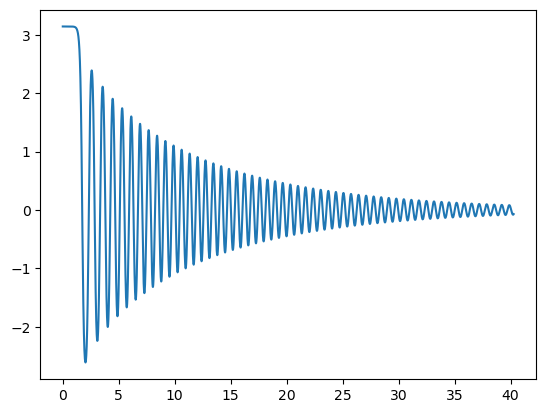

In [135]:
from matplotlib.pyplot import plot

s = create_trajectory(timestamps, *[m2, l2, J2, b2, initial_dy])
plot(timestamps, s[0])

# Comparison


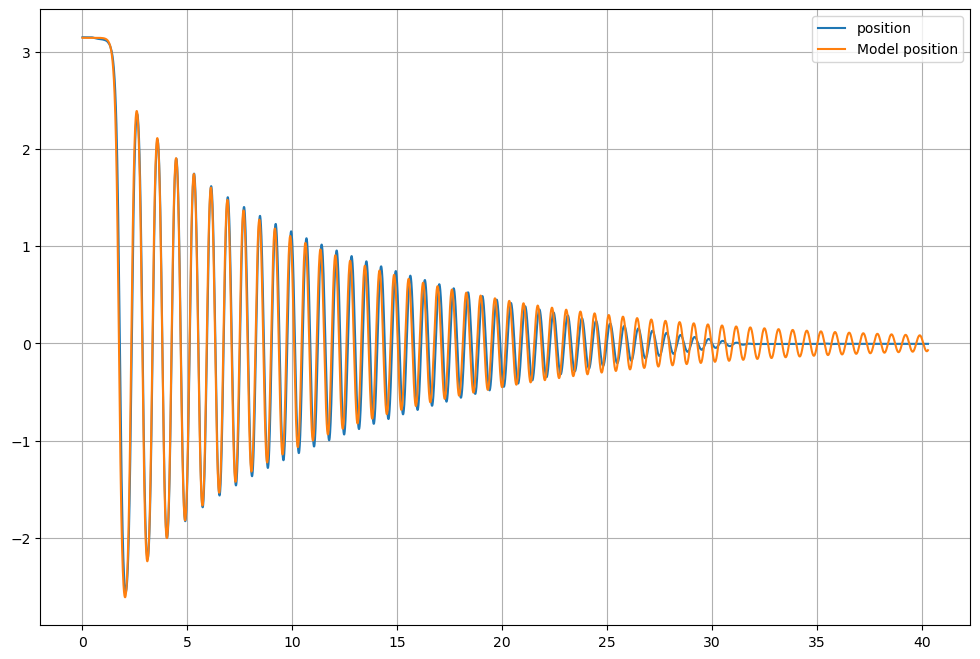

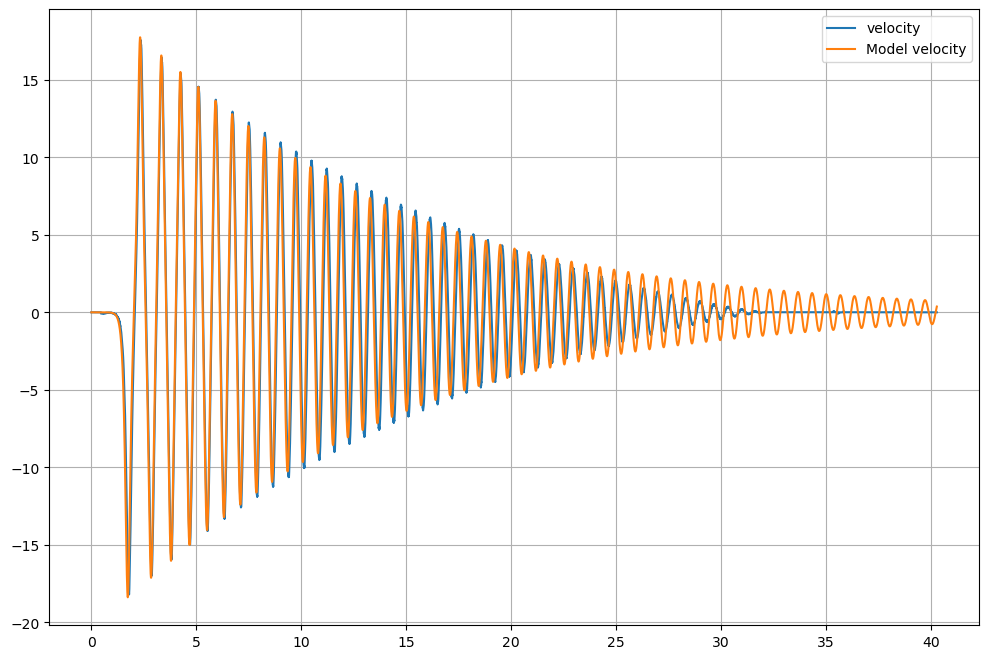

In [136]:
import matplotlib.pyplot as plt

for i in range(2):
    plt.figure(figsize=(12, 8))
    plot(timestamps, [x[i] for x in dataset], label=x_columns[i].split("/")[-1])
    plot(timestamps, s[i], label="Model " + x_columns[i].split("/")[-1])
    plt.legend()
    plt.grid(True)
    plt.show()

# Optimization

In [137]:
from scipy.optimize import curve_fit

min_scale = 0.1
max_scale = 10.0


min_bounds = [
    min_scale * m2,
    min_scale * l2,
    min_scale * J2,
    min_scale * b2,
    max_scale * initial_dy,
]
max_bounds = [
    max_scale * m2,
    max_scale * l2,
    max_scale * J2,
    max_scale * b2,
    min_scale * initial_dy,
]

initial_guess = [m2, l2, J2, b2, initial_dy]

x_desired = [x[0] for x in dataset]


def create_trajectory_j1_pos(timestamps, m2, l2, J2, b2, initial_dy):
    return create_trajectory(timestamps, m2, l2, J2, b2, initial_dy)[0]


opt_params, _ = curve_fit(
    create_trajectory_j1_pos,
    timestamps,
    x_desired,
    p0=initial_guess,
    bounds=(min_bounds, max_bounds),
)

<BarContainer object of 5 artists>

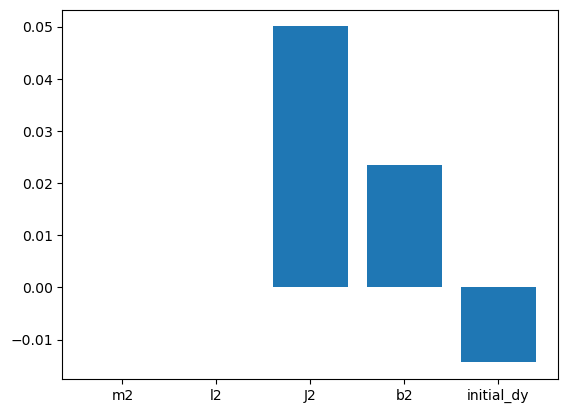

In [138]:
from matplotlib.pyplot import bar

bar(
    ["m2", "l2", "J2", "b2", "initial_dy"],
    (opt_params - initial_guess) / initial_guess,
)

In [139]:
print(f"m2: {opt_params[0]}")
print(f"l2: {opt_params[1]}")
print(f"J2: {opt_params[2]}")
print(f"b2: {opt_params[3]}")
print(f"y_initial: {opt_params[4]}")

m2: 0.009800835739906706
l2: 0.09661146964259201
J2: 1.553064756790078e-05
b2: 1.8326409843308807e-05
y_initial: -7.9521235920381e-06


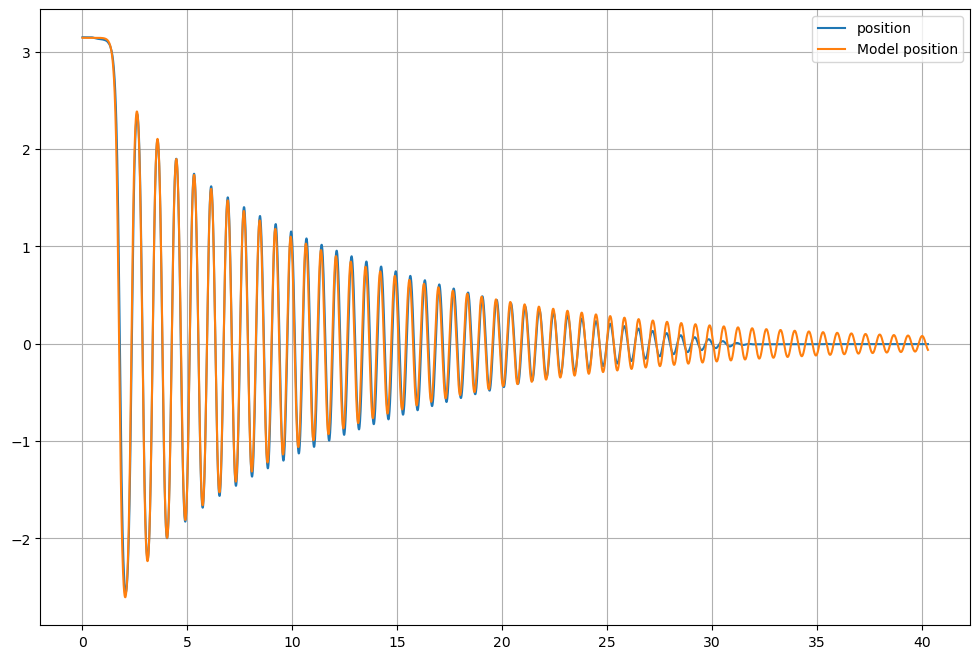

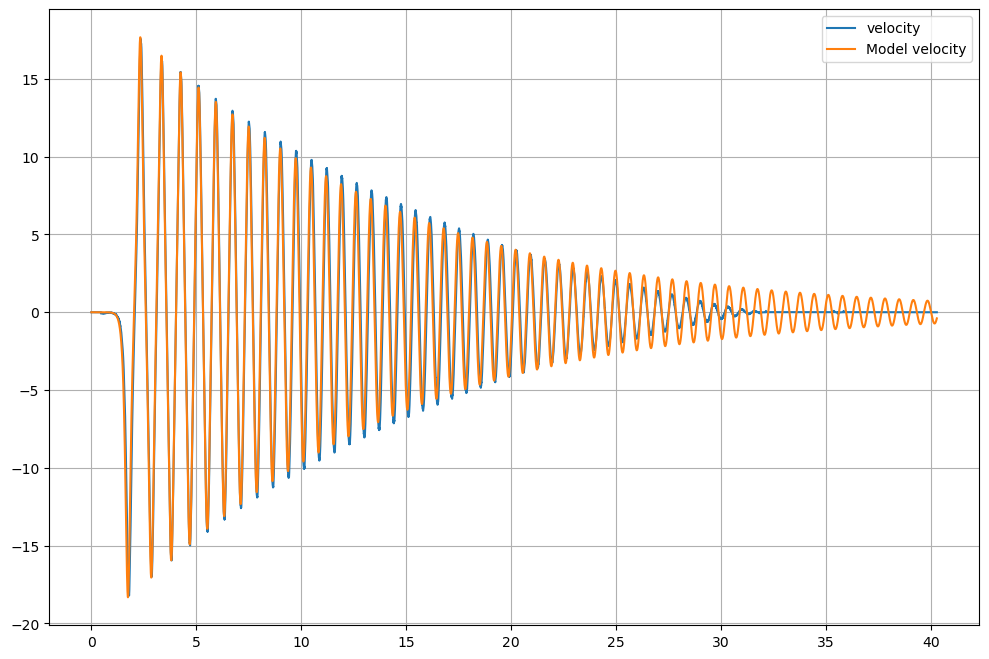

In [140]:
s = create_trajectory(timestamps, *opt_params)

for i in range(2):
    plt.figure(figsize=(12, 8))
    plot(timestamps, [x[i] for x in dataset], label=x_columns[i].split("/")[-1])
    plot(timestamps, s[i], label="Model " + x_columns[i].split("/")[-1])
    plt.legend()
    plt.grid(True)
    plt.show()